This is an attempt to build a model that given a cue word and some demographic data, tries to predict a set of possible responses.

Since the rows in the original data are grouped by participant, we need to shuffle the rows to get good train/test set splits.

In [40]:
# Loads modules and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing
from sklearn.decomposition import PCA

pd.set_option('max_rows', 10) # Sets the max number of rows to print

df = pd.read_csv('data/SWOW-EN.R100.csv', index_col = 0) # Reads in a CSV file
df = df.sample(frac=1).reset_index(drop=True) # Shuffles rows

/home/ansonl/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Let's try a simple word2vec model first to see what kind of predictions we can make. Thankfully all the pre-processing has already been done with this data set, so we don't need to do anything more with that.

Note that due to the number of cues (~12,000) and potential words involved here, it's probably very easy to overfit the data, so we'll have to be careful about choosing the model and inputs.

In [3]:
df

,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,549747,50189,25,Ma,Other_Foreign,Belgium,NaN,2012-02-22 15:52:37,goldfish,fish,green,yellow
1,268747,23765,25,Ma,Canada,Canada,NaN,2012-02-10 19:53:37,practical,realistic,fitting,internship
2,328832,29502,18,Ma,United States,United States,NaN,2012-02-11 01:22:24,twist,turn,pretzel,cone
3,291019,25928,25,Ma,United States,United States,NaN,2012-02-10 21:55:11,cough,hack,NyQuist,tissue
4,448686,41166,25,Fe,United Kingdom,United Kingdom,NaN,2012-02-15 08:05:53,transfer,figures,window,train
...,...,...,...,...,...,...,...,...,...,...,...,...
1228195,1336404,118825,21,Fe,United States,United States,4.0,2016-08-19 15:50:51,cut off,jeans,interrupt,scissors
1228196,796502,72877,29,Fe,United States,United States,NaN,2013-02-27 19:02:37,battlefield,war,blood,Jordain sparks
1228197,359853,32611,48,Fe,United Kingdom,United Kingdom,NaN,2012-02-11 05:22:42,crystal,clear,stone,sparkly
1228198,472788,43333,38,Fe,United States,United States,NaN,2012-02-15 17:07:48,spoon,feed,soup,antique


In [27]:
# Converts associations into "sentences"
sentences = []
for row in df.itertuples(index=True, name='Pandas'):
    associations = [str(getattr(row, "cue")),str(getattr(row, "R1")),str(getattr(row, "R1")),str(getattr(row, "R3"))]
    sentences.append(associations)

In [37]:
cores = multiprocessing.cpu_count()

# Initialize the Word2Vec model
model = Word2Vec(sentences,
                     min_count=5,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

In [38]:
# summarize model
print(model)

# summarize vocabulary
words = list(model.wv.vocab)
print(words[0:20])

Word2Vec(vocab=31784, size=300, alpha=0.03)
['opt', 'nan', 'lush', 'green', 'forest', 'caress', 'tender', 'sweet', 'it', 'object', 'pronoun', 'snatch', 'addicted', 'heroin', 'junkie', 'wrath', 'demon', 'scary', 'preference', 'personal']


In [39]:
# Saves model to file
model.wv.save_word2vec_format('model.bin') # Binary format, to save space
#model.wv.save_word2vec_format('model.txt', binary=False) # ASCII format, if you want to review the data later
# model = Word2Vec.load('model.bin') # Loads a model file

In [44]:
# retrieving all the vectors from the trained model
X = model[model.wv.vocab]

# Runs PCA on the word vectors to project these onto a plane
pca = PCA(n_components=2)
result = pca.fit_transform(X)

/home/ansonl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


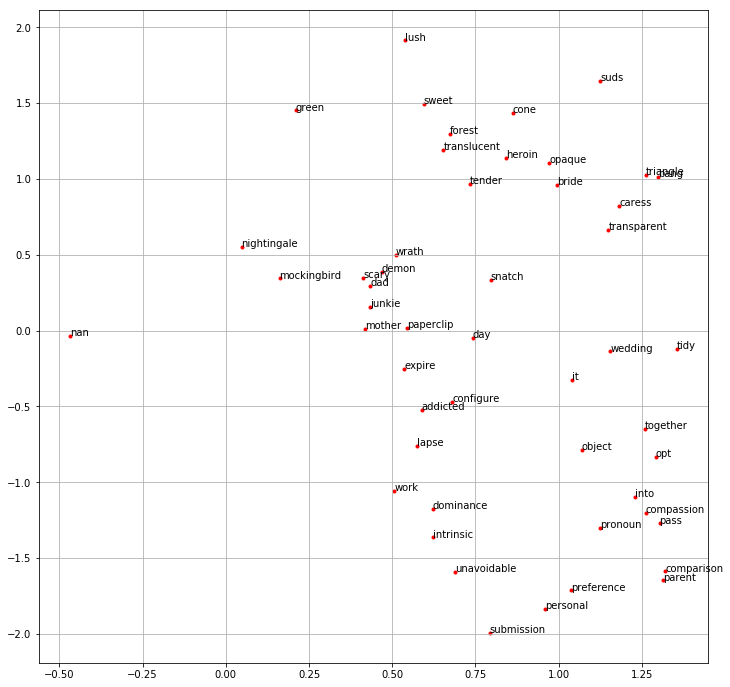

In [63]:
# Does plotting
max_words = 50


fig=plt.figure(figsize=(12, 12), facecolor='w', edgecolor='k')

plt.scatter(result[:max_words, 0], result[:max_words, 1],marker = '.',color='r')
for i, word in enumerate(words[:max_words]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.grid(True)
